# Project Exercise – Feature Engineering

Feature engineering is the act of making your data easier for a machine learning model to understand. You are not adding anything new but are reshaping and curating the existing data to make the existing patterns more apparent. Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work better than they would on a simple raw encoding.

To examine this, you will use the King County, Washington (which includes Seattle), housing dataset (CC0 license). You will try to predict the price of a house based on simple information like the location, total square footage, and number of bedrooms. You may imagine a business scenario where you are running a real estate brokerage and wish to predict for your customers the cost that a house will sell for if listed.

First, load the dataset and take a look at its basic properties.

In [2]:
# Load the dataset
import pandas as pd
import boto3

df = pd.read_csv("kc_house_data_2.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,N,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,N,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,N,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,N,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,N,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


This dataset has 21 columns:
* `id` - Unique id number
* `date` - Date of the house sale
* `price` - Price the house sold for
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Number of square feet of the living space
* `sqft_lot` - Number of square feet of the lot
* `floors` - Number of floors in the house
* `waterfront` - Whether the home is on the waterfront
* `view` - Number of lot sides with a view
* `condition` - Condition of the house
* `grade` - Classification by construction quality 
* `sqft_above` - Number of square feet above ground
* `sqft_basement` - Number of square feet below ground
* `yr_built` - Year built
* `yr_renovated` - Year renovated
* `zipcode` - ZIP code
* `lat` - Latitude
* `long` - Longitude
* `sqft_living15` - Number of square feet of living space in 2015 (can differ from `sqft_living` in the case of recent renovations)
* `sqrt_lot15` - Nnumber of square feet of lot space in 2015 (can differ from `sqft_lot` in the case of recent renovations)

This dataset is rich and provides a fantastic playground for the exploration of feature engineering. This exercise will focus on a small number of columns. If you are interested, you could return to this dataset later to practice feature engineering on the remaining columns.

## A baseline model

Now, train a baseline model.

People often look at square footage first when evaluating a home. You will do the same in the oflorur model and ask how well can the cost of the house be approximated based on this number alone. You will train a simple linear learner model ([documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html)). You will compare to this after finishing the feature engineering.

**Note:** This takes a few minutes to run, so feel free to read onward while you are waiting.

In [3]:
import sagemaker
import numpy as np
from sklearn.model_selection import train_test_split
import time

t1 = time.time()

# Split training, validation, and test
ys = np.array(df['price']).astype("float32")
xs = np.array(df['sqft_living']).astype("float32").reshape(-1,1)

np.random.seed(8675309)
train_features, test_features, train_labels, test_labels = train_test_split(xs, ys, test_size=0.2)
val_features, test_features, val_labels, test_labels = train_test_split(test_features, test_labels, test_size=0.5)

# Train model
linear_model = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                               instance_count=1,
                                               instance_type='ml.m4.xlarge',
                                               predictor_type='regressor')

train_records = linear_model.record_set(train_features, train_labels, channel='train')
val_records = linear_model.record_set(val_features, val_labels, channel='validation')
test_records = linear_model.record_set(test_features, test_labels, channel='test')

linear_model.fit([train_records, val_records, test_records], logs=False)

sagemaker.analytics.TrainingJobAnalytics(linear_model._current_job_name, metric_names = ['test:mse', 'test:absolute_loss']).dataframe()

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.



2021-03-11 19:39:49 Starting - Starting the training job
2021-03-11 19:39:51 Starting - Launching requested ML instances..............
2021-03-11 19:41:05 Starting - Preparing the instances for training..................
2021-03-11 19:42:42 Downloading - Downloading input data.....
2021-03-11 19:43:14 Training - Downloading the training image...
2021-03-11 19:43:35 Training - Training image download completed. Training in progress...
2021-03-11 19:43:50 Uploading - Uploading generated training model.
2021-03-11 19:43:58 Completed - Training job completed


,timestamp,metric_name,value
0,0.0,test:mse,6.960262e+10
1,0.0,test:absolute_loss,1.754493e+05


If you examine the quality metrics, you will see that the absolute loss is about $\$175,000.00$. This tells us that the model is able to predict within an average of $175k of the true price. For a model based upon a single variable, this is not bad. Let's try to do some feature engineering to improve on it.

Throughout the following work, you will constantly be adding to a dataframe called `encoded`. You will start by populating `encoded` with just the square footage you used previously.

In [4]:
encoded = df[['sqft_living']].copy()

## Categorical variables

Let's start by including some categorical variables, beginning with simple binary variables.

The dataset has the `waterfront` feature, which is a binary variable. We should change the encoding from `'Y'` and `'N'` to `1` and `0`. This can be done using the `map` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html)) provided by Pandas.  It expects either a function to apply to that column or a dictionary to look up the correct transformation.

> ### Question 1 - Binary categorical
> Write code to transform the `waterfront` variable into binary values. The skeleton has been provided below.

In [5]:
## SOLUTION 1 ##

encoded['waterfront'] = df['waterfront'].map({'Y':1, 'N':0})

You can also encode many class categorical variables. Look at column `condition`, which gives a score of the quality of the house. Looking into the [data source](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#b) shows that the condition can be thought of as an ordinal categorical variable, so it makes sense to encode it with the order.

> ### Question 2 -  Ordinal categorical
> Using the same method as in question 1, encode the ordinal categorical variable `condition` into the numerical range of 1 through 5.

In [6]:
## SOLUTION 2 ##

encoded['condition'] = df['condition'].map({'Poor':1, 'Fair':2, 'Average':3, 'Good':4, 'Very Good':5})

A slightly more complex categorical variable is ZIP code. If you have worked with geospatial data, you may know that the full ZIP code is often too fine-grained to use as a feature on its own. However, there are only $70$ unique ZIP codes in this dataset, so we may use them.

However, we do not want to use unencoded ZIP codes. There is no reason that a larger ZIP code should correspond to a higher or lower price, but it is likely that particular ZIP codes would. This is the perfect case to perform one-hot encoding. You can use the `get_dummies` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)) from Pandas to do this.

> ### Question 3 - Nominal categorical
> Using the Pandas `get_dummies` function, add columns to one-hot encode the ZIP code and add it to the dataset.

In [7]:
## Solution 3 ##

encoded = pd.concat([encoded, pd.get_dummies(df['zipcode'])], axis=1)

In this way, you may freely encode whatever categorical variables you wish. Be aware that for categorical variables with many categories, something will need to be done to reduce the number of columns created.

One additional technique, which is simple but can be highly successful, involves turning the ZIP code into a single numerical column by creating a single feature that is the average price of a home in that ZIP code. This is called target encoding.

To do this, use `groupby` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)) and `mean` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html)) to first group the rows of the DataFrame by ZIP code and then take the mean of each group. The resulting object can be mapped over the ZIP code column to encode the feature.

> ### Question 4 - Nominal categorical II
> Complete the following code snippet to provide a target encoding for the ZIP code.  

In [8]:
## Solution 4 ##
means = df.groupby('zipcode')['price'].mean()
encoded['zip_mean'] = df['zipcode'].map(means)

Normally, you only either one-hot encode or target encode. For this exercise, leave both in. In practice, you should try both, see which one performs better on a validation set, and then use that method.

## Scaling

Take a look at the dataset. Print a summary of the encoded dataset using `describe` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html)).

In [9]:
encoded.describe()

,sqft_living,waterfront,condition,98001,98002,98003,98004,98005,98006,98007,...,98148,98155,98166,98168,98177,98178,98188,98198,98199,zip_mean
count,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,...,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,2.161300e+04
mean,2079.899736,0.007542,3.409430,0.016749,0.009207,0.012955,0.014667,0.007773,0.023042,0.006524,...,0.002637,0.020636,0.011752,0.012446,0.011798,0.012122,0.006293,0.012955,0.014667,5.400881e+05
std,918.440897,0.086517,0.650743,0.128333,0.095515,0.113084,0.120219,0.087824,0.150039,0.080508,...,0.051288,0.142165,0.107771,0.110869,0.107981,0.109435,0.079077,0.113084,0.120219,2.343263e+05
min,290.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.342840e+05
25%,1427.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.594832e+05
50%,1910.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.935525e+05
75%,2550.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.452315e+05
max,13540.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.160607e+06


One column ranges from $290$ to $13540$ (`sqft_living`), another column ranges from $1$ to $5$ (`condition`), $71$ columns are all either $0$ or $1$ (one-hot encoded ZIP code), and then the final column ranges from a few hundred thousand to a couple million (`zip_mean`).

In a linear model, these will not be on equal footing. The `sqft_living` column will be approximately $13000$ times easier for the model to find a pattern in than the other columns. To solve this, you often want to scale features to a standardized range. In this case, you will scale `sqft_living` to lie within $0$ and $1$.

> ### Question 5 - Feature scaling
> Fill in the code skeleton below to scale the column of the DataFrame to be between $0$ and $1$.

In [10]:
## Solution 5 ##

sqft_min = encoded['sqft_living'].min()
sqft_max = encoded['sqft_living'].max()
encoded['sqft_living'] = encoded['sqft_living'].map(lambda x : (x-sqft_min)/(sqft_max - sqft_min))

cond_min = encoded['condition'].min()
cond_max = encoded['condition'].max()
encoded['condition'] = encoded['condition'].map(lambda x : (x-cond_min)/(cond_max - cond_min))

## Comparison with baseline

With this complete, you have now practiced some fundamentals of feature engineering. Take a look at how your new model compares with the baseline.

In [11]:
# Split training, validation, and test
ys = np.array(df['price']).astype("float32")
xs = np.array(encoded).astype("float32")

np.random.seed(8675309)
train_features, test_features, train_labels, test_labels = train_test_split(xs, ys, test_size=0.2)
val_features, test_features, val_labels, test_labels = train_test_split(test_features, test_labels, test_size=0.5)

# Train model
linear_model = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                               instance_count=1,
                                               instance_type='ml.m4.xlarge',
                                               predictor_type='regressor')

train_records = linear_model.record_set(train_features, train_labels, channel='train')
val_records = linear_model.record_set(val_features, val_labels, channel='validation')
test_records = linear_model.record_set(test_features, test_labels, channel='test')

linear_model.fit([train_records, val_records, test_records], logs=False)

sagemaker.analytics.TrainingJobAnalytics(linear_model._current_job_name, metric_names = ['test:mse', 'test:absolute_loss']).dataframe()

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.



2021-03-11 19:44:04 Starting - Starting the training job
2021-03-11 19:44:06 Starting - Launching requested ML instances.................
2021-03-11 19:45:35 Starting - Preparing the instances for training...................
2021-03-11 19:47:18 Downloading - Downloading input data.
2021-03-11 19:47:30 Training - Downloading the training image...
2021-03-11 19:47:50 Training - Training image download completed. Training in progress....
2021-03-11 19:48:06 Uploading - Uploading generated training model
2021-03-11 19:48:14 Completed - Training job completed


,timestamp,metric_name,value
0,0.0,test:mse,3.462124e+10
1,0.0,test:absolute_loss,1.073903e+05


This is improved! The error has been reduced from about $\$175k$ to $\$107k$, which is about a $38\%$ improvement in predictions.

Diving deeply into feature engineering is often one of the most powerful steps in the development of a model.  Whatever human understanding you can distill into well-engineered features is one less thing that your model needs to learn.

While we omitted exploratory data analysis here, doing so would quickly reveal there are many subtle relationships that can be modeled, such as the one graphed below for `price` vs. `lat`. Can you guess the latitude of downtown Seattle from this plot?

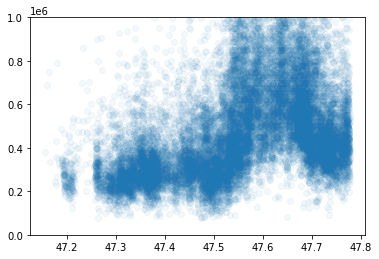

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.ylim([0,1000000])
plt.scatter(df['lat'],df['price'],alpha=0.05)
plt.show()

> ### Question 6 - Additional feature engineering (Optional)
> Continue performing feature engineering on this dataset. Here is a short list of things to try:
> * Perform binning or polynomial feature engineering on the latitude.
> * Try using only the first three digits of the ZIP code to see if fewer one-hot-encoded variables helps.
> * Include the other numerical features.
> * Test the effect of different scaling methods.
> * Use the renovation year to create a `has_been_renovated` variable. (What would go wrong if you used it without encoding it properly?)
> * Use the sale date.

In [13]:
## Possible solution 6 ##

encoded['bedrooms'] = df['bedrooms']
encoded['bathrooms'] = df['bathrooms']
encoded['sqft_lot'] = df['sqft_lot']
encoded['floors'] = df['floors']
encoded['view'] = df['view']
encoded['grade'] = df['grade']
encoded['sqft_above'] = df['sqft_above']
encoded['sqft_basement'] = df['sqft_basement']
encoded['bathrooms'] = df['bathrooms']
encoded['renovated'] = df['yr_renovated'].map(lambda x: 1 if x > 0 else 0)
encoded['lat'] = df['lat']
encoded['long'] = df['long']
encoded['lr1'] = df['lat'].map(lambda x: 1 if x <= 47.3 else 0)
encoded['lr2'] = df['lat'].map(lambda x: 1 if x > 47.3 and x <= 47.4 else 0)
encoded['lr3'] = df['lat'].map(lambda x: 1 if x > 47.4 and x <= 47.5 else 0)
encoded['lr4'] = df['lat'].map(lambda x: 1 if x > 47.5 and x <= 47.6 else 0)
encoded['lr5'] = df['lat'].map(lambda x: 1 if x > 47.6 and x <= 47.7 else 0)
encoded['lr6'] = df['lat'].map(lambda x: 1 if x > 47.7 else 0)

encoded = (encoded - encoded.min())/(encoded.max() - encoded.min())

In [14]:
encoded.describe()

,sqft_living,waterfront,condition,98001,98002,98003,98004,98005,98006,98007,...,sqft_basement,renovated,lat,long,lr1,lr2,lr3,lr4,lr5,lr6
count,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,...,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,0.135087,0.007542,0.602357,0.016749,0.009207,0.012955,0.014667,0.007773,0.023042,0.006524,...,0.060479,0.042289,0.650076,0.253408,0.037755,0.136862,0.131217,0.255957,0.270902,0.167307
std,0.069316,0.086517,0.162686,0.128333,0.095515,0.113084,0.120219,0.087824,0.150039,0.080508,...,0.091821,0.201253,0.222879,0.116967,0.190608,0.343710,0.337646,0.436408,0.444436,0.373258
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.085811,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.506836,0.158638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.122264,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.668972,0.240033,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.170566,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.116183,0.000000,0.839794,0.327243,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Split training, validation, and test
ys = np.array(df['price']).astype("float32")
xs = np.array(encoded).astype("float32")

np.random.seed(8675309)
train_features, test_features, train_labels, test_labels = train_test_split(xs, ys, test_size=0.2)
val_features, test_features, val_labels, test_labels = train_test_split(test_features, test_labels, test_size=0.5)

# Train model
linear_model = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                               instance_count=1,
                                               instance_type='ml.m4.xlarge',
                                               predictor_type='regressor')

train_records = linear_model.record_set(train_features, train_labels, channel='train')
val_records = linear_model.record_set(val_features, val_labels, channel='validation')
test_records = linear_model.record_set(test_features, test_labels, channel='test')

linear_model.fit([train_records, val_records, test_records], logs=False)

sagemaker.analytics.TrainingJobAnalytics(linear_model._current_job_name, metric_names = ['test:mse', 'test:absolute_loss']).dataframe()

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.



2021-03-11 19:48:24 Starting - Starting the training job
2021-03-11 19:48:26 Starting - Launching requested ML instances.............
2021-03-11 19:49:38 Starting - Preparing the instances for training...........
2021-03-11 19:50:39 Downloading - Downloading input data.

# Hyperparameter optimization

Now that you have prepared and trained the dataset, it is time to tune the model. What you tune for the model are the knobs or algorithm settings called hyperparameters. Hyperparameters can dramatically affect the performance of the trained models. For example, the linear learner algorithm has dozens of hyperparameters, and you must pick the right values for those hyperparameters to achieve the desired model training results. Selecting the hyperparameter setting that leads to the best result depends on the dataset as well. It is almost impossible to pick the best hyperparameter setting without searching for it, and a good search algorithm can search for the best hyperparameter setting in an automated and effective way.

You will use Amazon SageMaker hyperparameter tuning to automate the searching process effectively. Specifically, you will specify a range, or a list of possible values in the case of categorical hyperparameters, for each of the hyperparameters that we plan to tune. Amazon SageMaker hyperparameter tuning will automatically launch multiple training jobs with different hyperparameter settings, evaluate results of those training jobs based on a predefined "objective metric", and select the hyperparameter settings for future attempts based on previous results. For each hyperparameter tuning job, you will give a budget (max number of training jobs), and tuning will complete once that many training jobs have run.

You will use the Amazon SageMaker Python SDK again to set up and manage the hyperparameter tuning job.

You will tune two hyperparameters in this example:
- **learning_rate:** The step size used by the optimizer for parameter updates
- **use_bias:** Specifies whether the model should include a bias term, which is the intercept term in the linear equation

In [ ]:
from sagemaker.parameter import (
    CategoricalParameter,
    ContinuousParameter,
    IntegerParameter,
    ParameterRange,
)
from sagemaker.amazon.hyperparameter import Hyperparameter
from sagemaker.tuner import HyperparameterTuner
import sagemaker

hyperparameter_ranges = {'learning_rate': ContinuousParameter(0.0001, 0.1, scaling_type='Logarithmic'),
                        'use_bias': CategoricalParameter([True, False])}

Next, you'll specify the objective metric that you'd like to tune and its definition, which includes the regular expression (regex) needed to extract that metric from the Amazon CloudWatch logs of the training job.

Because you are using the built-in linear learner algorithm, it emits two predefined metrics that you have used before: **test: mse** and **test: absolute_loss**. You will elect to monitor **test:mse**. In this case, you only need to specify the metric name and do not need to provide regex. If you bring your own algorithm, your algorithm emits metrics by itself. In that case, you would need to add a metric definition object to define the format of those metrics through regex, so that Amazon SageMaker knows how to extract those metrics from your CloudWatch logs.

In [ ]:
objective_metric_name = 'test:mse'
objective_type = 'Minimize'

Now, create a HyperparameterTuner object, to which you will pass the following:  
- The Linear_model estimator created previously
- The hyperparameter ranges
- Objective metric name and definition with the objective type
- Tuning resource configurations, such as number of training jobs to run in total and how many training jobs can be run in parallel

In [ ]:
tuner = HyperparameterTuner(linear_model,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10,
                            max_parallel_jobs=2,
                            objective_type=objective_type)

Now you can launch a hyperparameter tuning job by calling the `fit()` function. After the hyperparameter tuning job is created, you can go to the Amazon SageMaker console to track the progress of the hyperparameter tuning job until it is completed.

In [ ]:
tuner.fit([train_records, val_records, test_records], include_cls_metadata=False)

Run a quick check of the hyperparameter tuning job status to make sure it started successfully.

In [ ]:
sagemaker_client = boto3.client('sagemaker')

job_name = tuner.latest_tuning_job.job_name

tuner_describe = sagemaker_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=job_name)['HyperParameterTuningJobStatus']
tuner_describe

### Track hyperparameter tuning job progress

After you launch a tuning job, you can see its progress by calling the `describe_tuning_job` API. The output is a JSON object that contains information about the current state of the tuning job. To see a detailed list of the training jobs that the tuning job launched, call `list_training_jobs_for_tuning_job`.

In [ ]:
tuning_job_result = sagemaker_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed" % job_count)
    
is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']

In [ ]:
from pprint import pprint
if tuning_job_result.get('BestTrainingJob',None):
    print("Best model found so far:")
    pprint(tuning_job_result['BestTrainingJob'])
else:
    print("No training jobs have reported results yet.")

### Fetch all results as DataFrame

You can list hyperparameters and objective metrics of all training jobs and pick up the training job with the best objective metric.

In [ ]:
import pandas as pd

tuner = sagemaker.HyperparameterTuningJobAnalytics(job_name)

full_df = tuner.dataframe()

if len(full_df) > 0:
    df = full_df[full_df['FinalObjectiveValue'] > -float('inf')]
    if len(df) > 0:
        df = df.sort_values('FinalObjectiveValue', ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest":min(df['FinalObjectiveValue']),"highest": max(df['FinalObjectiveValue'])})
        pd.set_option('display.max_colwidth', -1)  # Don't truncate TrainingJobName        
    else:
        print("No training jobs have reported valid results yet.")
        
df



## Conclusion

In this exercise, you examined a few tasks in feature engineering and hyperparameter optimization. First, you saw how you can encode features that are otherwise inaccessible to the model (such as the categorical features). In these circumstances, simple techniques like one-hot encoding or ordinal encoding can go a long way. These techniques also allowed you to get more from the features you already had, such as with the latitude. The encoding was already good in that case; however, the pattern was difficult for the model to use. Presenting that variable in a way that makes the data available to the model is a key to the development of a high-performing model.